# Численное моделирование распространения сейсмических волн в двумерной среде MILEN SEM 2D

## Часть III: Построение модели в формате fc.

Задача: построение модели в формате FidesysCase. По возможности огрубить сетку

Теперь у нас есть все нужные данные. Осталось построить модель в fidesys-совместимом формате fc.

Загружаем библиотеки, включая fc_model

In [21]:

import numpy as np
import sys
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, List, Dict, Any

from fc_model import FCModel, FCMaterial, FCBlock, FCMaterialProperty, FCData, FCElement




Загружаем данные

In [22]:

def load_original_data():
    """Загрузка оригинальных данных материалов и сетки."""
    print("Загрузка оригинальных данных...")

    # Загрузка материалов
    material_data = np.load('model1_material.npz')
    kriging_params = material_data['kriging_params']

    # Загрузка сетки
    mesh_data = np.load('model1_mesh_coords.npz', allow_pickle=True)
    x_coords = mesh_data['x_coordinates']
    z_coords = mesh_data['z_coordinates']

    print(f"Оригинальные материалы: {kriging_params.shape} (Vp, плотность, Vs)")
    print(f"Оригинальная сетка: {x_coords.shape[0]}×{z_coords.shape[1]} узлов")
    print(f"Оригинальные элементы: {(x_coords.shape[0]-1)}×{(z_coords.shape[1]-1)}")

    return kriging_params, x_coords, z_coords

# Загрузка оригинальных данных
kriging_params, x_coords, z_coords = load_original_data()

Загрузка оригинальных данных...
Оригинальные материалы: (1175, 244, 3) (Vp, плотность, Vs)
Оригинальная сетка: 1176×245 узлов
Оригинальные элементы: 1175×244


Пишем функцию генерации fc-моделей

In [23]:

def build_fc_model_from_arrays(x_coords, z_coords, vp, density, vs, output_path):
    """
    Построение fc модели из массивов данных.

    Args:
        x_coords: координаты X узлов
        z_coords: координаты Z узлов (nx, nz)
        vp: скорости Vp (nx-1, nz-1)
        density: плотности (nx-1, nz-1)
        vs: скорости Vs (nx-1, nz-1)
        output_path: путь для сохранения fc файла
    """
    print(f"Построение FC модели: {vp.shape[0]}×{vp.shape[1]} элементов")

    # Объединяем свойства в один массив
    kriging_params = np.stack([vp, density, vs], axis=2)

    # Создание модели
    model = FCModel()

    # Настройки для 2D упругой модели
    model.settings = {
        "type": "dynamic",
        "dimensions": "2D",
        "plane_state": "p-strain",
        "elasticity": True,
        "finite_deformations": False,
        "lumpmass": False,
        "damping": {
            "type": "rayleigh",
            "alpha": 0.0,
            "beta": 0.0
        }
    }

    # Добавление узлов
    nx, nz = x_coords.shape[0], z_coords.shape[1]

    # Векторизованное создание координат узлов
    x_flat = np.repeat(x_coords, nz)
    y_flat = z_coords.flatten()
    z_flat = np.zeros_like(x_flat)

    nodes_xyz = np.stack([x_flat, y_flat, z_flat], axis=1)
    node_ids = np.arange(1, nx * nz + 1, dtype=np.int32)

    model.mesh.nodes_ids = node_ids
    model.mesh.nodes_xyz = nodes_xyz

    # Добавление элементов
    element_id = 1
    elements_created = 0

    for i in range(nx - 1):
        for j in range(nz - 1):
            n1 = i * nz + j + 1
            n2 = (i + 1) * nz + j + 1
            n3 = (i + 1) * nz + (j + 1) + 1
            n4 = i * nz + (j + 1) + 1

            element = FCElement({
                'id': element_id,
                'type': 'QUAD4',
                'nodes': [n1, n2, n3, n4],
                'block': 1,
                'parent_id': 0,
                'order': 1
            })

            model.mesh.add(element)
            element_id += 1
            elements_created += 1

    # Создание материала
    num_elements = (nx - 1) * (nz - 1)

    # Векторные операции для расчета свойств
    vp_flat = vp.flatten()
    density_flat = density.flatten()
    vs_flat = vs.flatten()

    # Перевод плотности из г/см³ в кг/м³
    density_kgm3 = density_flat * 1000

    # Расчет модуля Юнга и коэффициента Пуассона
    vp2 = vp_flat ** 2
    vs2 = vs_flat ** 2

    young_moduli = density_kgm3 * vs2 * (3 * vp2 - 4 * vs2) / (vp2 - vs2)
    poisson_ratios = (vp2 - 2 * vs2) / (2 * (vp2 - vs2))
    densities = density_kgm3

    elements_ids = np.arange(1, num_elements + 1, dtype=np.float64)

    # Создаем материал с табличными свойствами
    material_dict = {
        'id': 1,
        'name': f'model_{nx-1}x{nz-1}_material',
    }

    material = FCMaterial(material_dict)
    material.properties = {
        'elasticity': [[
            FCMaterialProperty(
                'HOOK', "YOUNG_MODULE",
                FCData(young_moduli.astype(np.float64), [10], [elements_ids])
            ),
            FCMaterialProperty(
                'HOOK', "POISSON_RATIO",
                FCData(poisson_ratios.astype(np.float64), [10], [elements_ids])
            )
        ]],
        'common': [[
            FCMaterialProperty(
                'USUAL', "DENSITY",
                FCData(densities.astype(np.float64), [10], [elements_ids])
            )
        ]]
    }

    model.materials[1] = material

    # Создание блока
    block = FCBlock({
        'id': 1,
        'cs_id': 0,
        'material_id': 1,
        'property_id': 0
    })

    model.blocks[1] = block

    # Сохранение модели
    print(f"Сохранение модели в {output_path}...")
    model.save(output_path)

    return elements_created, len(node_ids)


Для исследования нам потребуется несколько сеток с разными размерами элементов. Сделаем функцию для огрубления сетки посредством усреднения материала при слиянии элементов

In [24]:
def create_coarse_grid(dx_target, dz_target, kriging_params, x_coords, z_coords):
    """
    Создание грубой сетки с заданными размерами ячеек.

    Args:
        dx_target: желаемый размер ячейки по горизонтали (м)
        dz_target: желаемый размер ячейки по вертикали (м)
        kriging_params: массив свойств материала (nx, nz, 3)
        x_coords: координаты X узлов (nx,)
        z_coords: координаты Z узлов (nx, nz)

    Returns:
        tuple: (coarse_kriging, coarse_x, coarse_z)
    """
    print(f"Создание грубой сетки {dx_target}×{dz_target} м...")

    nx_orig, nz_orig = kriging_params.shape[0], kriging_params.shape[1]

    # Оригинальные размеры
    dx_orig = 10.0  # м (известно из предыдущих расчетов)
    dz_orig = 10.0  # м

    # Размеры грубой сетки
    nx_coarse = int(np.ceil((nx_orig * dx_orig) / dx_target))
    nz_coarse = int(np.ceil((nz_orig * dz_orig) / dz_target))

    print(f"Оригинальная сетка: {nx_orig}×{nz_orig} элементов")
    print(f"Грубая сетка: {nx_coarse}×{nz_coarse} элементов")

    # Создаем грубые массивы
    coarse_kriging = np.zeros((nx_coarse, nz_coarse, 3))
    coarse_x = np.linspace(x_coords[0], x_coords[-1], nx_coarse + 1)
    coarse_z = np.zeros((nx_coarse + 1, nz_coarse + 1))

    # Факторы агрегации
    x_factor = max(1, int(np.ceil(dx_target / dx_orig)))
    z_factor = max(1, int(np.ceil(dz_target / dz_orig)))

    print(f"Факторы агрегации: x={x_factor}, z={z_factor}")

    # Агрегация свойств материала
    for i in range(nx_coarse):
        for j in range(nz_coarse):
            # Границы блока в оригинальной сетке
            i_start = i * x_factor
            i_end = min((i + 1) * x_factor, nx_orig)
            j_start = j * z_factor
            j_end = min((j + 1) * z_factor, nz_orig)

            # Усреднение свойств в блоке
            block = kriging_params[i_start:i_end, j_start:j_end, :]
            coarse_kriging[i, j, :] = np.mean(block, axis=(0, 1))

            # Усреднение Z координат
            z_block = z_coords[i_start:i_end, j_start:j_end]
            if z_block.size > 0:
                coarse_z[i, j] = np.mean(z_block)

    # Заполняем границы
    coarse_z[:, -1] = coarse_z[:, -2] + dz_target
    coarse_z[-1, :] = coarse_z[-2, :]

    return coarse_kriging, coarse_x, coarse_z


In [25]:

# Комбинации размеров сетки
grid_sizes = [
    (10, 10),  # оригинальная
    (50, 10),
    (50, 40)
]

results = []

for dx, dz in grid_sizes:
    print(f"\n{'='*60}")
    print(f"СОЗДАНИЕ МОДЕЛИ {dx}×{dz} м")
    print(f"{'='*60}")

    # Создание грубой сетки
    coarse_kriging, coarse_x, coarse_z = create_coarse_grid(
        dx, dz, kriging_params, x_coords, z_coords
    )

    # Разделение свойств
    vp_coarse = coarse_kriging[:, :, 0]
    density_coarse = coarse_kriging[:, :, 1]
    vs_coarse = coarse_kriging[:, :, 2]

    # Создание имени файла
    output_file = f"model1_{dx}x{dz}.fc"

    # Построение модели
    elements_count, nodes_count = build_fc_model_from_arrays(
        coarse_x, coarse_z, vp_coarse, density_coarse, vs_coarse, output_file
    )

    print(f"✓ Модель {dx}×{dz} создана успешно!")
    print(f"  Файл: {output_file}")
    print(f"  Элементов: {elements_count}")
    print(f"  Узлов: {nodes_count}")

    results.append({
        'dx': dx,
        'dz': dz,
        'file': output_file,
        'elements': elements_count,
        'nodes': nodes_count
    })

# Итоговый отчет
print(f"\n{'='*80}")
print("ИТОГОВЫЙ ОТЧЕТ")
print(f"{'='*80}")

for result in results:
    print(f"{result['dx']:3d}×{result['dz']:2d} м: {result['elements']:6d} элементов, {result['nodes']:6d} узлов - {result['file']}")

print(f"\nВсего создано моделей: {len(results)}/{len(grid_sizes)}")



СОЗДАНИЕ МОДЕЛИ 10×10 м
Создание грубой сетки 10×10 м...
Оригинальная сетка: 1175×244 элементов
Грубая сетка: 1175×244 элементов
Факторы агрегации: x=1, z=1
Построение FC модели: 1175×244 элементов
Сохранение модели в model1_10x10.fc...
✓ Модель 10×10 создана успешно!
  Файл: model1_10x10.fc
  Элементов: 286700
  Узлов: 288120

СОЗДАНИЕ МОДЕЛИ 50×10 м
Создание грубой сетки 50×10 м...
Оригинальная сетка: 1175×244 элементов
Грубая сетка: 235×244 элементов
Факторы агрегации: x=5, z=1
Построение FC модели: 235×244 элементов
Сохранение модели в model1_50x10.fc...
✓ Модель 50×10 создана успешно!
  Файл: model1_50x10.fc
  Элементов: 57340
  Узлов: 57820

СОЗДАНИЕ МОДЕЛИ 50×40 м
Создание грубой сетки 50×40 м...
Оригинальная сетка: 1175×244 элементов
Грубая сетка: 235×61 элементов
Факторы агрегации: x=5, z=4
Построение FC модели: 235×61 элементов
Сохранение модели в model1_50x40.fc...
✓ Модель 50×40 создана успешно!
  Файл: model1_50x40.fc
  Элементов: 14335
  Узлов: 14632

ИТОГОВЫЙ ОТЧЕТ
 10×

Природа нашей задачи требует от нас адаптировать размер элемента по высоте в зависимости от слоистости окрестного материала. Так и сделаем:

In [26]:

def build_adaptive_fc_model(kriging_params: np.ndarray, x_coords: np.ndarray, z_coords: np.ndarray,
                           threshold_percent: float = 10.0, max_merge_layers: int = 5,
                           output_path: str = "adaptive_model.fc"):
    """
    Построение адаптивной FC модели с использованием геологической геометрии.

    Args:
        kriging_params: массив свойств материала (nx, nz, 3)
        x_coords: координаты X узлов
        z_coords: координаты Z узлов (nx+1, nz+1) - геологическая геометрия
        threshold_percent: порог схожести слоев в процентах
        max_merge_layers: максимальное количество объединяемых слоев (по умолчанию 5 = 50м)
        output_path: путь для сохранения fc файла
    """
    print(f"Построение адаптивной модели с порогом {threshold_percent}% (макс. {max_merge_layers} слоев)...")

    # 1. Агрегируем по горизонтали до 50м, сохраняя геологическую геометрию
    coarse_kriging, coarse_x, coarse_z = create_coarse_grid(
        50.0, 10.0, kriging_params, x_coords, z_coords
    )

    # 2. Объединяем похожие слои с ограничением по количеству
    merged_kriging, merged_z, merge_info = merge_similar_layers(
        coarse_kriging, coarse_z, threshold_percent, max_merge_layers
    )

    # 3. Разделяем свойства
    vp_merged = merged_kriging[:, :, 0]
    density_merged = merged_kriging[:, :, 1]
    vs_merged = merged_kriging[:, :, 2]

    # 4. Строим FC модель
    elements_count, nodes_count = build_fc_model_from_arrays(
        coarse_x, merged_z, vp_merged, density_merged, vs_merged, output_path
    )

    # 5. Выводим статистику объединения
    print("\nСтатистика объединения слоев:")
    total_original = sum(info['element_count'] for info in merge_info)
    total_merged = len(merge_info)
    total_thickness_merged = sum(info['merged_thickness'] for info in merge_info)

    print(f"  Оригинальных слоев: {total_original}")
    print(f"  Объединенных слоев: {total_merged}")
    print(f"  Коэффициент сжатия: {total_original/total_merged:.1f}")
    print(f"  Общая толщина объединенных слоев: {total_thickness_merged:.1f} м")
    print(f"  Максимум объединенных слоев: {max_merge_layers}")

    # for i, info in enumerate(merge_info):
    #     print(f"  Слой {i+1}: {info['element_count']} элементов, толщина {info['merged_thickness']:.1f} м")

    return elements_count, nodes_count, merge_info


def merge_similar_layers(coarse_kriging: np.ndarray, coarse_z: np.ndarray,
                                   threshold_percent: float, max_merge_layers: int):
    """
    Объединение похожих слоев в адаптивную сетку с геологической геометрией.

    Args:
        coarse_kriging: массив свойств (nx, nz, 3)
        coarse_z: массив координат Z (nx+1, nz+1)
        threshold_percent: порог схожести в процентах
        max_merge_layers: максимальное количество объединяемых слоев

    Returns:
        tuple: (merged_kriging, merged_z, merge_info)
    """
    print(f"Анализ {coarse_z.shape[1]-1} слоев для объединения (макс. {max_merge_layers} слоев)...")

    nz = coarse_z.shape[1] - 1  # количество слоев
    nx = coarse_kriging.shape[0]
    merged_layers = []
    merged_z: list = []
    merge_info = []
    i = 0

    while i < nz:
        # Начинаем новый объединенный слой
        current_indices = [i]
        current_z_start = coarse_z[nx//2, i]  # берем Z из середины по горизонтали
        current_z_end = coarse_z[nx//2, i+1]

        # Усредняем свойства в текущем слое
        current_layer = coarse_kriging[:, i:i+1, :].mean(axis=1)

        # Пытаемся объединить с последующими слоями
        j = i + 1
        while j < nz and len(current_indices) < max_merge_layers:
            # Проверяем схожесть
            next_layer = coarse_kriging[:, j:j+1, :].mean(axis=1)

            # Вычисляем максимальную относительную разницу по всем свойствам
            max_diff = 0
            for prop_idx in range(3):
                current_val = current_layer[:, prop_idx].mean()
                next_val = next_layer[:, prop_idx].mean()
                if current_val != 0:
                    rel_diff = abs(next_val - current_val) / abs(current_val) * 100
                    max_diff = max(max_diff, rel_diff)

            # Если схожесть достаточная, объединяем
            if max_diff <= threshold_percent:
                # Обновляем усредненные свойства
                total_elements = len(current_indices) + 1
                current_layer = (current_layer * len(current_indices) + next_layer) / total_elements

                # Обновляем индексы и конечную координату Z
                current_indices.append(j)
                current_z_end = coarse_z[nx//2, j+1]  # обновляем Z из геометрии

                # print(f"Объединены слои {current_indices} (макс. разница: {max_diff:.1f}%)")
                j += 1
            else:
                break

        # Сохраняем объединенный слой
        merged_layers.append(current_layer)
        if not merged_z:  # Первый слой
            merged_z.append(current_z_start)
        merged_z.append(current_z_end)

        # Информация об объединении
        merge_info.append({
            'original_indices': current_indices,
            'element_count': len(current_indices),
            'merged_thickness': current_z_end - current_z_start
        })

        i = j  # Переходим к следующему необработанному слою

    # Создаем финальные массивы
    merged_kriging = np.array(merged_layers).transpose(1, 0, 2)  # (nx, n_merged, 3)

    # Правильно строим merged_z_array, сохраняя геологическую геометрию
    merged_z_array = np.zeros((nx + 1, len(merged_z)))
    for layer_idx, z_value in enumerate(merged_z):
        merged_z_array[:, layer_idx] = z_value

    # Но нужно сохранить горизонтальную вариацию Z-координат из coarse_z
    # Для каждого объединенного слоя берем Z-координаты из соответствующих слоев coarse_z
    merged_z_array_fixed = np.zeros((nx + 1, len(merged_z)))
    merged_z_array_fixed[:, 0] = coarse_z[:, 0]  # Первый слой всегда остается

    current_coarse_layer = 0
    for merged_idx in range(1, len(merged_z)):
        # Находим, какие coarse слои были объединены для этого merged слоя
        merged_info = merge_info[merged_idx-1]
        original_indices = merged_info['original_indices']

        # Используем Z-координату из последнего слоя в объединении
        last_original_idx = original_indices[-1] + 1  # +1 потому что это конец слоя
        merged_z_array_fixed[:, merged_idx] = coarse_z[:, last_original_idx]

    print(f"Результат: {len(merged_layers)} объединенных слоев из {nz} оригинальных")

    return merged_kriging, merged_z_array_fixed, merge_info




def create_adaptive_models(thresholds):
    """
    Создание адаптивных моделей с разными порогами схожести.

    Args:
        thresholds: список порогов схожести в процентах
    """
    print("=" * 80)
    print("СОЗДАНИЕ АДАПТИВНЫХ МОДЕЛЕЙ")
    print("=" * 80)

    # Загрузка данных
    kriging_params, x_coords, z_coords = load_original_data()

    results = []

    for threshold in thresholds:
        print(f"\n{'='*60}")
        print(f"ПОРОГ СХОЖЕСТИ: {threshold}%")
        print(f"{'='*60}")

        try:
            output_file = f"model1_50a{threshold:.0f}p.fc"

            elements_count, nodes_count, merge_info = build_adaptive_fc_model(
                kriging_params, x_coords, z_coords, threshold, max_merge_layers=5, output_path=output_file
            )

            print(f"✓ Адаптивная модель создана успешно!")
            print(f"  Файл: {output_file}")
            print(f"  Элементов: {elements_count}")
            print(f"  Узлов: {nodes_count}")

            results.append({
                'threshold': threshold,
                'file': output_file,
                'elements': elements_count,
                'nodes': nodes_count,
                'merge_info': merge_info
            })

        except Exception as e:
            print(f"✗ ОШИБКА при создании модели с порогом {threshold}%: {e}")
            import traceback
            traceback.print_exc()

    # Итоговый отчет
    print(f"\n{'='*80}")
    print("ИТОГОВЫЙ ОТЧЕТ")
    print(f"{'='*80}")

    for result in results:
        merged_layers = len(result['merge_info'])
        total_original = sum(info['element_count'] for info in result['merge_info'])
        compression = total_original / merged_layers if merged_layers > 0 else 1.0

        print(f"{result['threshold']:4.0f}%: {result['elements']:6d} элементов, {result['nodes']:6d} узлов, "
              f"сжатие {compression:.1f}x - {result['file']}")

    print(f"\nВсего создано адаптивных моделей: {len(results)}/{len(thresholds)}")

create_adaptive_models([1.0, 2.0, 3.0, 4.0, 5.0])


СОЗДАНИЕ АДАПТИВНЫХ МОДЕЛЕЙ
Загрузка оригинальных данных...
Оригинальные материалы: (1175, 244, 3) (Vp, плотность, Vs)
Оригинальная сетка: 1176×245 узлов
Оригинальные элементы: 1175×244

ПОРОГ СХОЖЕСТИ: 1.0%
Построение адаптивной модели с порогом 1.0% (макс. 5 слоев)...
Создание грубой сетки 50.0×10.0 м...
Оригинальная сетка: 1175×244 элементов
Грубая сетка: 235×244 элементов
Факторы агрегации: x=5, z=1
Анализ 244 слоев для объединения (макс. 5 слоев)...
Результат: 147 объединенных слоев из 244 оригинальных
Построение FC модели: 235×147 элементов
Сохранение модели в model1_50a1p.fc...

Статистика объединения слоев:
  Оригинальных слоев: 244
  Объединенных слоев: 147
  Коэффициент сжатия: 1.7
  Общая толщина объединенных слоев: 2370.6 м
  Максимум объединенных слоев: 5
✓ Адаптивная модель создана успешно!
  Файл: model1_50a1p.fc
  Элементов: 34545
  Узлов: 34928

ПОРОГ СХОЖЕСТИ: 2.0%
Построение адаптивной модели с порогом 2.0% (макс. 5 слоев)...
Создание грубой сетки 50.0×10.0 м...
Ориг

Сравним модели 50x40, 50x10, и 50a5p визуально:

image_50a5p
![Визуализация модели image_50a5p](img/image_50a5p.png)
image_50x10
![Визуализация модели image_50x10](img/image_50x10.png)
image_50x40
![Визуализация модели image_50x40](img/image_50x40.png)


Можно видеть, что адаптивная сетка 5%, мало уступая 50x40 по числу элементов (3.3 против 4 раз сжатия) дает гораздо более качественную сетку, близкую к эталонной 50x10.

Теперь сравним 50x10, 1%, 2%, 3%, 4%, 5%:

image_50x10
![Визуализация модели image_50x10](img/image_50x10.png)
image_50a1p
![Визуализация модели image_50a1p](img/image_50a1p.png)
image_50a2p
![Визуализация модели image_50a2p](img/image_50a2p.png)
image_50a3p
![Визуализация модели image_50a3p](img/image_50a3p.png)
image_50a4p
![Визуализация модели image_50a4p](img/image_50a4p.png)
image_50a5p
![Визуализация модели image_50a5p](img/image_50a5p.png)


Визуально кажется, что где-то между 4% и 5% происходит скачок огрубления и целый набор слоев смазывается (это виднно как на указанных рисунках плотности так и для других упругих модулей); в сравнении других вариантов различие не такое уж сильное. 4% дает хорошую степень сжатия - почти в 3 раза.


Теперь сравним по плотности в районе первой скважины:

In [27]:
def extract_density_profile_at_x(density_array: np.ndarray, x_coords: np.ndarray, z_coords: np.ndarray,
                                target_x: float = 4250.0):
    """
    Извлекает профиль плотности вдоль вертикальной линии с заданной X-координатой.

    Args:
        density_array: массив плотности (nx, nz)
        x_coords: координаты X (nx+1,)
        z_coords: координаты Z (nx+1, nz+1)
        target_x: целевая X-координата

    Returns:
        tuple: (z_values, density_values) - Z-координаты и соответствующие значения плотности
    """
    # Находим индекс ближайшей X-координаты
    x_center = (x_coords[:-1] + x_coords[1:]) / 2  # центры элементов по X
    x_idx = np.argmin(np.abs(x_center - target_x))

    # Извлекаем профиль плотности вдоль выбранной вертикальной линии
    density_profile = density_array[x_idx, :]

    # Используем Z-координаты из центра сетки для профиля
    z_center_idx = x_coords.shape[0] // 2
    z_values = z_coords[z_center_idx, :-1]  # Z-координаты элементов (без последней границы)

    return z_values, density_profile
def plot_density_profiles_comparison(thresholds: List[float] = [1.0, 2.0, 3.0, 4.0, 5.0]):
    """
    Строит график сравнения профилей плотности для всех моделей вдоль X=4250.

    Args:
        thresholds: список порогов схожести в процентах для адаптивных моделей
    """
    print("\n" + "="*80)
    print("ПОСТРОЕНИЕ ГРАФИКА ПРОФИЛЕЙ ПЛОТНОСТИ")
    print("="*80)

    # Загружаем оригинальные данные
    kriging_params, x_coords, z_coords = load_original_data()

    # Создаем базовую модель 50×10
    base_kriging, base_x, base_z = create_coarse_grid(50.0, 10.0, kriging_params, x_coords, z_coords)

    # Создаем адаптивные модели с заданными порогами
    adaptive_models = []

    for threshold in thresholds:
        print(f"Создание адаптивной модели с порогом {threshold}%...")

        # Агрегируем по горизонтали до 50м
        coarse_kriging, coarse_x, coarse_z = create_coarse_grid(
            50.0, 10.0, kriging_params, x_coords, z_coords
        )

        # Объединяем похожие слои
        merged_kriging, merged_z, merge_info = merge_similar_layers(
            coarse_kriging, coarse_z, threshold, max_merge_layers=5
        )

        adaptive_models.append({
            'threshold': threshold,
            'density': merged_kriging[:, :, 1],  # индекс 1 - плотность
            'x_coords': coarse_x,
            'z_coords': merged_z,
            'merge_info': merge_info
        })

    # Настраиваем график
    plt.figure(figsize=(15, 10))

    # Создаем rainbow градиент для адаптивных моделей
    n_thresholds = len(thresholds)
    rainbow_colors = [plt.cm.rainbow(i / n_thresholds) for i in range(n_thresholds)]

    # Базовая модель всегда красная
    base_color = 'black'

    labels = ['Базовая 10'] + [f'Адаптивная {t:.0f}%' for t in thresholds]

    # Строим профиль для базовой модели
    z_base, density_base = extract_density_profile_at_x(
        base_kriging[:, :, 1], base_x, base_z, target_x=4250.0
    )
    plt.plot(density_base, z_base, color=base_color, linewidth=3, label=labels[0], zorder=1)


    # Строим профили для адаптивных моделей
    for i, model in enumerate(adaptive_models):
        z_profile, density_profile = extract_density_profile_at_x(
            model['density'], model['x_coords'], model['z_coords'], target_x=4250.0
        )
        plt.plot(density_profile, z_profile, color=rainbow_colors[i], linewidth=2,
                label=labels[i+1], alpha=0.8, zorder=2)



    # Настраиваем внешний вид графика
    plt.xlabel('Плотность (г/см³)', fontsize=14)
    plt.ylabel('Глубина (м)', fontsize=14)
    plt.title('Профили плотности вдоль X=4250 м (первая скважина)', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    # Инвертируем ось Y (глубина увеличивается вниз)
    plt.gca().invert_yaxis()

    # Добавляем дополнительную информацию
    info_text = f"Сравнение профилей плотности:\n"
    info_text += f"• Базовая модель: {base_kriging.shape[0]}×{base_kriging.shape[1]} элементов\n"

    for model in adaptive_models:
        merged_layers = len(model['merge_info'])
        total_original = sum(info['element_count'] for info in model['merge_info'])
        compression = total_original / merged_layers if merged_layers > 0 else 1.0
        info_text += f"• Порог {model['threshold']:.0f}%: {model['density'].shape[0]}×{model['density'].shape[1]} элементов (сжатие {compression:.1f}x)\n"

    plt.figtext(0.02, 0.02, info_text, fontsize=10, verticalalignment='bottom',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))

    # Сохраняем график
    plt.tight_layout()
    plt.savefig('density_profiles_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ График сохранен в файл: density_profiles_comparison.png")

    # Показываем график
    plt.show()



ПОСТРОЕНИЕ ГРАФИКА ПРОФИЛЕЙ ПЛОТНОСТИ
Загрузка оригинальных данных...
Оригинальные материалы: (1175, 244, 3) (Vp, плотность, Vs)
Оригинальная сетка: 1176×245 узлов
Оригинальные элементы: 1175×244
Создание грубой сетки 50.0×10.0 м...
Оригинальная сетка: 1175×244 элементов
Грубая сетка: 235×244 элементов
Факторы агрегации: x=5, z=1
Создание адаптивной модели с порогом 1%...
Создание грубой сетки 50.0×10.0 м...
Оригинальная сетка: 1175×244 элементов
Грубая сетка: 235×244 элементов
Факторы агрегации: x=5, z=1
Анализ 244 слоев для объединения (макс. 5 слоев)...
Результат: 147 объединенных слоев из 244 оригинальных
Создание адаптивной модели с порогом 2%...
Создание грубой сетки 50.0×10.0 м...
Оригинальная сетка: 1175×244 элементов
Грубая сетка: 235×244 элементов
Факторы агрегации: x=5, z=1
Анализ 244 слоев для объединения (макс. 5 слоев)...
Результат: 113 объединенных слоев из 244 оригинальных
Создание адаптивной модели с порогом 4%...
Создание грубой сетки 50.0×10.0 м...
Оригинальная сетк

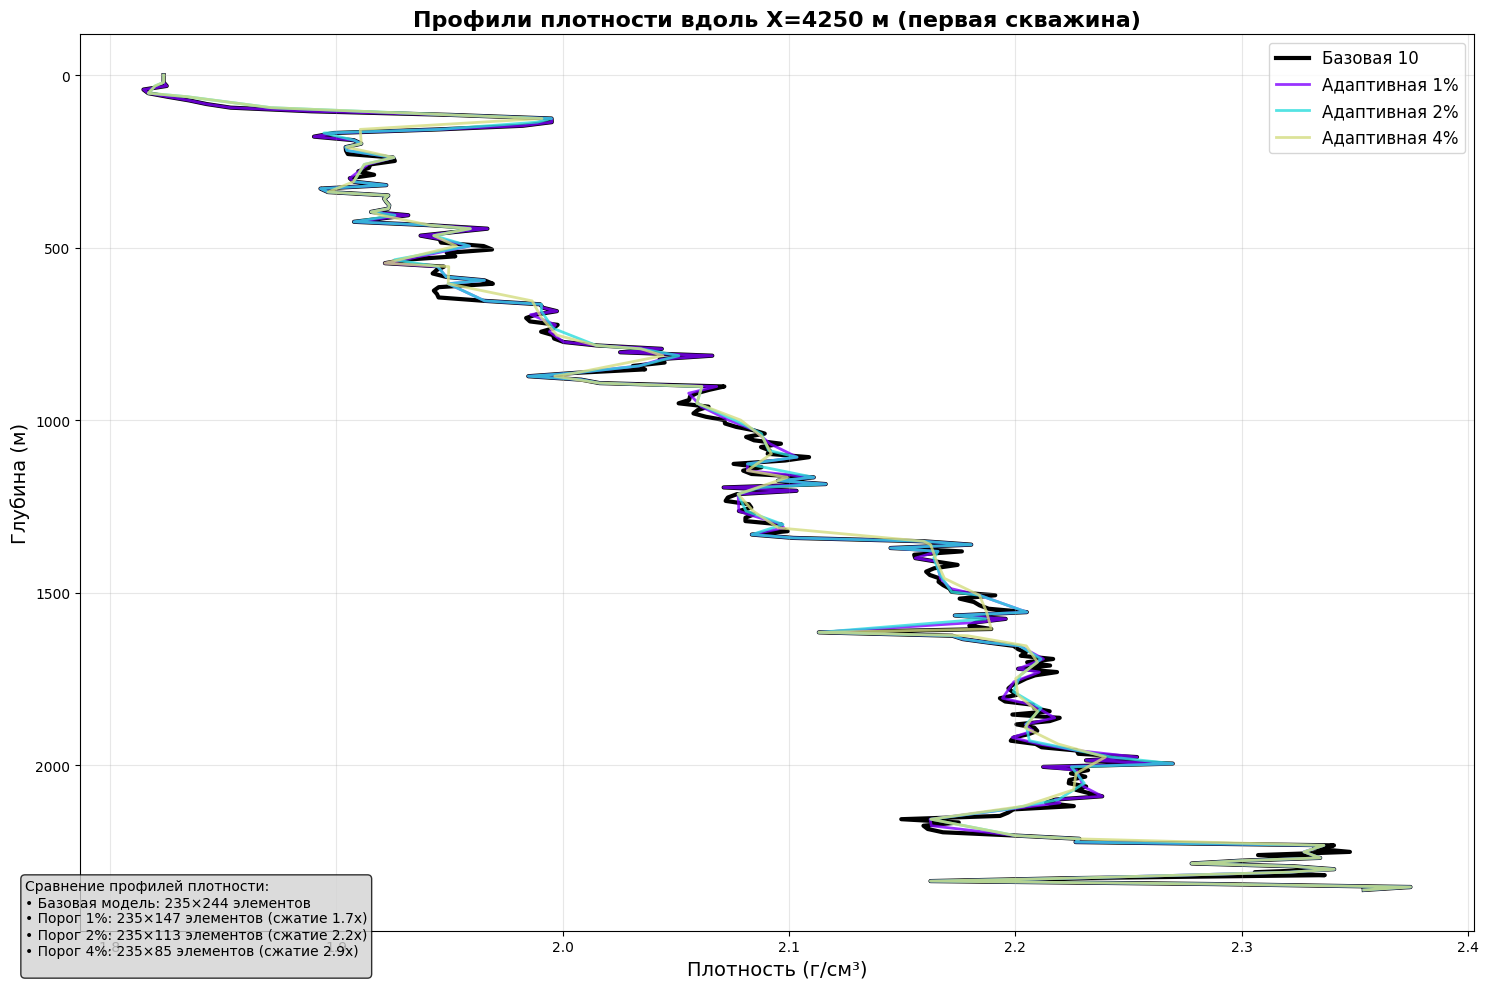

In [33]:
plot_density_profiles_comparison([1,2,4])


Будем использовать model1_50a4p.fc (4% сглаживания) как каноническую модель *model1.fc*


## Итоговые характеристики геометрии модели


- Элементов по вертикали: 85
- Элементов по горизонтали: 235
- Элементов: 19975 = 235 x 85
- Узлов: 20296
- Общая толщина объединенных слоев: ~2370.6 м
- Ширина 235*50 = 11750 м